# Figures and Tables

### Imports

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt
from shapely.wkt import loads

import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sn
from datetime import datetime

In [2]:
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

csfont = {'fontname':'Adobe Garamond Pro','fontsize':30}
hfont = {'fontname':'Adobe Garamond Pro','fontsize':15}

sn.set_style("white")

### Read and prepare Data / Apply general filters

In [3]:
MUNICIPALITIES_IN_MRM = ["005", "006", "007", "022", "026", "045", "049", "058", "065", "073", "074", "080", "084", "092", "104", "106", "113", "115", "127", "130", "134", "148", "167", "176", "177", "181", "184", "079","123","903"]

In [4]:
#Read Data
df = pd.read_csv(r"../data/level1_edm2018.csv",sep=",")
#Filter Metropolitan Region of Madrid
df = df[df['ZT1259'].str.startswith(tuple(MUNICIPALITIES_IN_MRM))]
df['CODMUNI'] = df['CODMUNI'].astype(str).str.zfill(3)
#Drop duplicate trips
df.drop_duplicates(subset=['ID_HOGAR','ID_IND','ID_VIAJE'],inplace=True)
#Only one-way trips
df = df[df['VDES']!='Casa']
df = df[df['C8ACTIV']!='Otra situación']

In [5]:
#DateTime format
df['VORIHORAINI'] = df['VORIHORAINI'].astype(int).astype(str).str.zfill(4).str[:2] + ":" + df['VORIHORAINI'].astype(int).astype(str).str.zfill(4).str[2:]
df['VDESHORAFIN'] = df['VDESHORAFIN'].astype(int).astype(str).str.zfill(4).str[:2] + ":" + df['VDESHORAFIN'].astype(int).astype(str).str.zfill(4).str[2:]
df = df[~df['VDESHORAFIN'].str.startswith(("25","26"))]
df = df[~df['VORIHORAINI'].str.startswith(("25","26"))]
df.loc[df['VORIHORAINI'].str.startswith("24"),'VORIHORAINI'] = df[df['VORIHORAINI'].str.startswith("24")]['VORIHORAINI'].str.replace("24:","00:")
df.loc[df['VDESHORAFIN'].str.startswith("24"),'VDESHORAFIN'] = df[df['VDESHORAFIN'].str.startswith("24")]['VDESHORAFIN'].str.replace("24:","00:")
df['VDESHORAFIN'] = pd.to_datetime(df['VDESHORAFIN'], format= '%H:%M' )
df['VORIHORAINI'] = pd.to_datetime(df['VORIHORAINI'], format= '%H:%M' )
df['DURACION_VIAJE'] = ((df['VDESHORAFIN'] - df['VORIHORAINI']).dt.seconds)/60
df['VELOCIDAD_VIAJE'] = df['DISTANCIA_VIAJE']/(df['DURACION_VIAJE']/60)
df['DURACION_VIAJE'].fillna(0,inplace=True)
df['VELOCIDAD_VIAJE'].fillna(0,inplace=True)
df['VDESHORAFIN'] = df['VDESHORAFIN'].dt.hour
df['VORIHORAINI'] = df['VORIHORAINI'].dt.hour

C:\Users\katul\AppData\Local\Temp\ipykernel_972\404733503.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DURACION_VIAJE'].fillna(0,inplace=True)
C:\Users\katul\AppData\Local\Temp\ipykernel_972\404733503.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

In [6]:
#Filter initial outliers
df = df[df['VELOCIDAD_VIAJE'] < 80] #Too fast trips
df = df[df['DURACION_VIAJE'] < 300] #Too long (time) trips
df = df[df['DURACION_VIAJE'] >= 0] #Too brief trips
df = df[df['N_VIAJES_POR_HOGAR'] < 20] #Too many trips per household
df = df[df['DISTANCIA_VIAJE'] < 20] #Too long (kilometer) trips

### Read and prepare Data / Map categorical values

In [7]:
categorical = {
    'C2SEXO':('Gender',{'Hombre':'Male','Mujer':'Female'},(0,0)),
    'C4NAC':('Foreign',{'No':'Yes','Si':'No'},(0,1)),
    'CPMR':('PRM',{'No':'No','Si':'Yes'},(1,0)),
    'C13TARJETA':('TravelCard',{'Tarjeta de Transporte Público TTP':"Yes", 'Ninguna':"No", 'Ambas tarjetas':"Yes",'Tarjeta MULTI':"Yes"},(1,1)),
    'VVEHICULO':('HasVehicle',{'Si':'Yes','No':'No'},(2,0)),
    'C6CARNE':('HasLicense',{'No tiene':"No", 'Carné de coche (B) o superior  (C, D ó E)':"Yes",'Carné de moto y coche':"Yes", 'Carné de moto A1/A2':"Yes", 'Sólo licencia de ciclomotor':"Yes"},(2,1)),
    'VFRECUENCIA':('Frequency',{'A diario, de lunes a viernes':"Daily",'Entre 2 y 4 días laborables por semana':"Frequently",'Es la primera vez que hago el viaje':"0",'Menos de dos días laborables por semana':"Less Frequently", 'Alguna vez':"Sometimes"},(3,0)),
    'DIASEM':('DayOfWeek',{"Lunes":"Monday","Martes":"Tuesday","Miércoles":"Wednesday","Jueves":"Thursday"},(3,1)),
    'C7ESTUD':('EducationLevel',{'Primera etapa de Educación Secundaria y similar':"Second - A",'Educación Primaria':"First",'Segunda etapa de Educación Secundaria y similar':"Second - B",'Menos que Primaria':"No",'Enseñanzas de Formación Profesional de grado superior y equivalentes':"Third",'Educación postsecundaria no superior':"Second - B", 'Grados universitarios/licenciaturas/másteres y enseñanzas de doctorado':"Third"},(4,0)),
    'C8ACTIV':('Activity',{'Parado, ha trabajado antes':"Unemployed", 'Jubilado / Retirado/ Pensionista':"Retired",'Estudiante':"Student", 'Trabaja':"Worker", 'Trabaja y estudia':"Worker",'Cuidado de familiares':"Caretaker", 'Trabajo doméstico no remunerado':"Caretaker", 'Parado, busca primer trabajo':"Unemployed"},(4,1)),
    'VNOPRIVADO':("NoPrivate",{'No me gusta el coche':"Dislike", 'Más incómodo':"Less Convenient",'Evitar el atasco':"Congestion",'Contamino menos':"Other",'Dificultad de aparcamiento':"Hard to Park",'Otros':"Other",'Tardo más':"Takes Longer",'Es más caro':"Other"},(5,0)),
    'VNOPUBLICO':("NoPublic",{'No hay servicio público':"Bad Service",'Es más caro':"Other",'Tardo más':"Takes Longer",'El destino está muy cerca':"Very Close",'Otros':"Other",'Necesito mi vehículo para trabajar o gestión personal':"Other",'Mala combinación del tte.público':"Bad Service",'Prefiero ir andando / en bicicleta':"Prefer Active Modes",'Mi situación personal condiciona esta elección modal':"Bad Service",'Más incómodo':"Less Convenient", 'Por desconocimiento/falta de información':"Other",'No me gusta el tte. público':"Other"},(5,1)),
    "MOTIVO_PRIORITARIO":("TripPurpose",{'Compras':"Shopping",'Ocio':"Leisure",'Estudio':"Study",'Trabajo':"Work",'Deporte/ dar un paseo':"Sport / Stroll",'Otro domicilio':"Other",'Asunto personal':"Other",'Acompañamiento a otra persona':"Care",'Médico':"Care",'Gestión de trabajo':"Work",'Otros':"Other"},(6,0)),
    "MODO_PRIORITARIO":("TransportMode",{'Coche conductor particular' :"Motor - Personal",'Coche pasajero particular':"Motor - Personal",'Moto/ciclomotor particular':"Motor - Personal",'Andando/pie' : "Walking",'Autobus urbano Madrid EMT':"Bus",'Autobus interurbano':"Bus",'Autobus discrecional':"Bus",'Autobus de largo recorrido':"Bus",'Autobus urbano otro municipio':"Bus",'Otros':"Other",'Metro':"Train",'Renfe Cercanías':"Train",'Resto renfe':"Train",'Metro ligero/tranvía':"Train", 'Coche conductor empresa' : "Motor - Shared",'Coche pasajero empresa': "Motor - Shared",'Taxi':"Motor - Shared",'Coche pasajero alquiler con conductor': "Motor - Shared",'Coche conductor alquiler sin conductor': "Motor - Shared",'Moto/ciclomotor empresa': "Motor - Shared",'Moto/ciclomotor publica': "Motor - Shared",'Bicicleta particular':"Cycling",'Bicicleta publica':"Cycling",'Bicicleta empresa':"Cycling"},(6,1))
    }

#Iterate over categorical columns and rename
for c,i in categorical.items():
    df[c] = df[c].map(i[1])
    df.rename(columns={c:i[0]},inplace=True)

### Read and prepare Data / Prepare continuous columns

In [8]:
df.rename(columns = {'DISTANCIA_VIAJE':'TripDistance'},inplace=True)
continuous = {
    'EDAD_FIN':('Age',(0,0)),
    'N_MIEMBROS_POR_HOGAR':('HouseholdSize',(0,1)),
    'N_VIAJES_POR_HOGAR':('TripsHousehold',(1,0)),
    'N_ETAPAS_POR_VIAJE':('TripStages',(1,1)),
    'VORIHORAINI':('StartTime',(2,0)),
    'VDESHORAFIN':('EndTime',(2,1)),
    'DURACION_VIAJE':('TripDuration',(3,0)),
    'VELOCIDAD_VIAJE':('TripSpeed',(3,1))
    }

#Iterate over continuous columns and rename
for c,i in continuous.items():
    df.rename(columns={c:i[0]},inplace=True)
    df[i[0]] = df[i[0]].astype(float)

### Read and prepare Data / Prepare age and household structure columns

In [9]:

df.loc[df['Age']<5,'Age Status'] = "Less than 5"
df.loc[(df['Age']>=5) & (df['Age']<12),'Age Status'] = "Ages 6-12"
df.loc[(df['Age']>=12) & (df['Age']<18),'Age Status'] = "Ages 13-18"
df.loc[(df['Age']>=18) & (df['Age']<40),'Age Status'] = "Ages 19-40"
df.loc[(df['Age']>=40) & (df['Age']<65),'Age Status'] = "Ages 41-65"
df.loc[df['Age']>=65,'Age Status'] = "More than 65"

hd = {}
h15 = {}
h30 = {}
for h in list(df['ID_HOGAR'].unique()):
    dist = list(df[df['ID_HOGAR'] == h]['TripDuration'].values)
    
    if all(di < 30 for di in dist): h30.update({h:1})
    else: h30.update({h:0})
    
    if all(di < 15 for di in dist): h15.update({h:1})
    else: h15.update({h:0})

    hd.update({h:'Other'})
    d = df[df['ID_HOGAR'] == h][['ID_IND','Age','Age Status','HouseholdSize','Activity']].drop_duplicates(subset='ID_IND')
    if d['HouseholdSize'].values[0] == 1:
        if d['Activity'].values[0] == 'Retired': hd.update({h:'Retirees'})
        elif d['Activity'].values[0] == 'Student': hd.update({h:'Students (age 19+)'})
        elif d['Activity'].values[0] in ['Worker']: hd.update({h:'Full-Time Workers'})
        else: hd.update({h:'Other'})
    else:
        if any(act in ['Retired'] for act in d['Activity'].values): hd.update({h:'Retirees'})
        if any(act in ['Worker'] for act in d['Activity'].values): hd.update({h:'Full-Time Workers'})
        if any(age == "Ages 13-18" for age in d['Age Status'].values): hd.update({h:'Students (Age 13–18)'})
        if any(age == "Ages 6-12" for age in d['Age Status'].values): hd.update({h:'Students (Age 6–12)'})
        if any(age == "Less than 5" for age in d['Age Status'].values): hd.update({h:'Children'})
        

df['HouseholdStructure'] = df['ID_HOGAR'].map(hd)
df['Household15min'] = df['ID_HOGAR'].map(h15)
df['Household30min'] = df['ID_HOGAR'].map(h30)

df['Household30min'] = df['Household30min'].map({0:"No",1:"Yes"})
df['Household15min'] = df['Household15min'].map({0:"No",1:"Yes"})

### Read and prepare Data / Filter 15 minute trips

In [10]:
df['Trip15'] = ""
df.loc[df['TripDuration']<=15,'Trip15'] = 'Yes'
df.loc[df['TripDuration']>15,'Trip15'] = 'No'

### Further preparations

In [11]:
#Prepare data (this data is in the datalake and not in the data repository)

gdf_ine = gpd.read_file(r"G:\Mi unidad\walknet_datalake\sources\ine_geo\level1\level1_ine_geo_2018.gpkg")
muni_ref = gdf_ine[(gdf_ine['boundary_type'] == "municipality")&(gdf_ine['municipality_code'].isin(["28005", "28006", "28007", "28022", "28026", "28045", "28049", "28058", "28065", "28073", "28074", "28080", "28084", "28092", "28104", "28106", "28113", "28115", "28127", "28130", "28134", "28148", "28167", "28176", "28177", "28181", "28903", "28079","28123","28903"]))]
muni_ref['geometry'] = muni_ref['geometry'].boundary

gdf = gpd.read_file(r"G:\Mi unidad\walknet_datalake\sources\edm_geo\level0\ZonificacionZT1259.shp")
gdf = gdf[gdf['ZT1259'].str.startswith(("005", "006", "007", "022", "026", "045", "049", "058", "065", "073", "074", "080", "084", "092", "104", "106", "113", "115", "127", "130", "134", "148", "167", "176", "177", "181", "184", "079","123","903"))]
gdf = gdf.to_crs(25830)
gdf['centroid'] = gdf.geometry.representative_point()

gdf['CODMUNI'] = gdf['ZT1259'].str.split("-").str[0]

env = pd.read_csv(r"G:\Mi unidad\walknet_datalake\extractions\density_new.csv")


p = r"G:\Mi unidad\walknet_datalake\sources\catastro\level2"

urban = pd.concat([pd.read_csv(os.path.join(p,f),sep=";") for f in os.listdir(p) if "_polygon" in f])
urban.geometry = urban.geometry.apply(wkt.loads)
urban = gpd.GeoDataFrame(urban,geometry='geometry',crs=25830)

merged = pd.merge( env[env['boundary_type']!='tz'].set_index('boundary_id'),
gdf_ine[['boundary_code','geometry']].set_index('boundary_code'), left_index=True, right_index=True)
merged = gpd.GeoDataFrame(merged,geometry='geometry',crs=25830)

inter = gpd.overlay(urban, merged.reset_index(), how='intersection')
inter['urban_area'] = inter.geometry.area

merged['urban_area'] = merged.index.map({k:v for k,v in inter.groupby('index')['urban_area'].sum().to_dict().items() if k})
merged['NetDensity'] = merged['population'] / (merged['urban_area'] / 10000)
merged['NetDensity'].fillna(0,inplace=True)
merged['NetDensity'] = merged['NetDensity'].astype(int)
merged = merged[merged['NetDensity']>-1]
merged['boundary_type'].unique()

merged_tz = pd.merge( env[env['boundary_type']=='tz'].set_index('boundary_id'),
gdf[['ZT1259','geometry']].set_index('ZT1259'), left_index=True, right_index=True)

merged_tz = gpd.GeoDataFrame(merged_tz,geometry='geometry',crs=25830)

inter = gpd.overlay(urban, merged_tz.reset_index(), how='intersection')
inter['urban_area'] = inter.geometry.area

merged_tz['urban_area'] = merged_tz.index.map(inter.groupby('index')['urban_area'].sum().to_dict())

merged_tz['NetDensity'] = merged_tz['population'] / (merged_tz['urban_area'] / 10000)
merged_tz['NetDensity'] = merged_tz['NetDensity'].fillna(0).astype(int)
merged_tz = merged_tz[merged_tz['NetDensity']>0]


def quantiles(data:pd.Series):
    return pd.qcut(data, np.linspace(0,1,5), labels= np.linspace(0.25,1,4), duplicates='drop')

merged_tz.sort_values(by='NetDensity')

merged_tz['NetDensityL'] = quantiles(merged_tz['NetDensity'])

for a in ['municipality','district','census_tract']:
    merged.loc[(merged['boundary_type']==a)&(merged['NetDensity']>0),'NetDensityL'] = quantiles(merged[merged['boundary_type']==a]['NetDensity'])

c:\Documents\Github\pw_sources\env\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Documents\Github\pw_sources\env\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: G:\Mi unidad\walknet_datalake\sources\edm_geo\level0\ZonificacionZT1259.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
C:\Users\katul\AppData\Local\Temp\ipykernel_972\2117364570.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will ne

In [12]:
merged_tz = pd.merge( env[env['boundary_type']=='tz'].set_index('boundary_id'),
gdf[['ZT1259','geometry']].set_index('ZT1259'), left_index=True, right_index=True)

merged_tz = gpd.GeoDataFrame(merged_tz,geometry='geometry')
merged_tz['NetDensity'] = merged_tz['population'] / (merged_tz['parcel_area'] / 1000000)
merged_tz['NetDensity'] = merged_tz['NetDensity'].fillna(0).astype(int)

df[(df['TripPurpose'].isin(['Shopping', 'Leisure', 'Care', 'Sport / Stroll'])) & (df['TransportMode']=='Motor - Personal')].groupby(['VDESZT1259','TripPurpose'])['ELE_G_POND'].sum().reset_index().set_index('VDESZT1259')

merged_frequency = pd.merge(df[(df['TripPurpose'].isin(['Shopping', 'Leisure', 'Care', 'Sport / Stroll'])) & (df['TransportMode']=='Motor - Personal')].groupby(['VDESZT1259','TripPurpose'])['ELE_G_POND'].sum().reset_index().set_index('VDESZT1259'), merged_tz, left_index=True,right_index=True)


In [13]:
df['CODMUNI'] = df['CODMUNI'].astype(str)
df['TransportMode'] = df['TransportMode'].astype(str)
df['ELE_G_POND'] = pd.to_numeric(df['ELE_G_POND'], errors='coerce')

merged_tz['NetDensityL'] = quantiles(merged_tz['NetDensity'])

merged_tz = merged_tz[merged_tz['NetDensity']>0]

### Figure 12 Number of Trips by categories

C:\Users\katul\AppData\Local\Temp\ipykernel_972\3523643632.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(d.index, rotation=0,**hfont)
C:\Users\katul\AppData\Local\Temp\ipykernel_972\3523643632.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(d.index, rotation=0,**hfont)
C:\Users\katul\AppData\Local\Temp\ipykernel_972\3523643632.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(d.index, rotation=0,**hfont)
C:\Users\katul\AppData\Local\Temp\ipykernel_972\3523643632.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(d.index, rotation=0,**hfont)
C:\Users\katul\AppData\Local

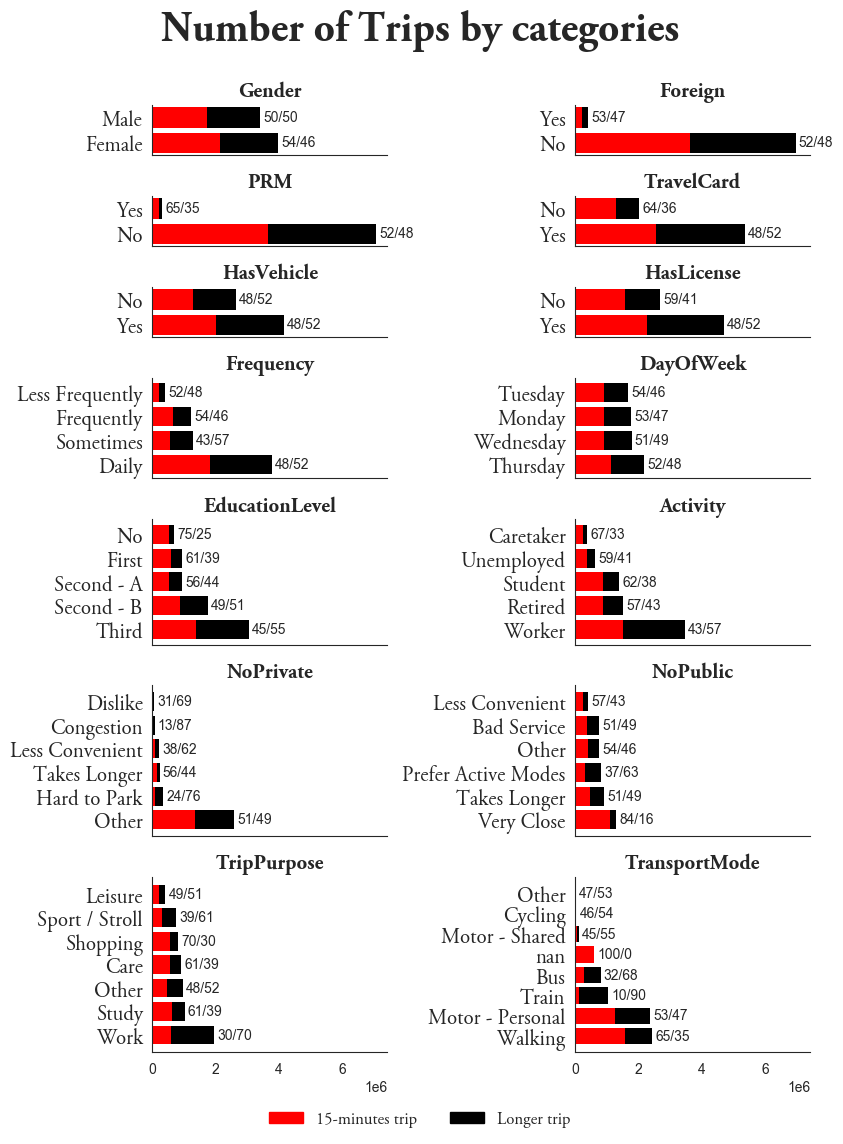

In [14]:


fig, axs = plt.subplots(7, 2, figsize=(8.5, 11), gridspec_kw={'height_ratios': [2, 2, 2, 4,5,6,7]},sharex=True) 

#fig.add_gridspec(nrows=7, ncols=2, height_ratios=[2, 2, 2, 4,5,6,7])

fig.suptitle('Number of Trips by categories', fontweight="bold", y=1, **csfont)  # Title

colors = {"15-minutes trip": "red", "longer trip": "black"}

for c, i in categorical.items():
    d = df.copy(deep=True)

    d['15MC'] = d['TripDuration'].apply(lambda x: "15-minutes trip" if x <= 15 else "longer trip")

    d = d.groupby([i[0], '15MC'])['ELE_G_POND'].sum().unstack().fillna(0)
    d = d.loc[d.index != "0"]
    
    # Sort the dataframe by the sum of ELE_G_POND values
    d['Total'] = d.sum(axis=1)
    d = d.sort_values(by='Total', ascending=False).drop(columns='Total')
    
    a = axs[i[2][0]][i[2][1]]
    
    # Plot each category manually to control the colors
    bottom = [0] * len(d)
    for category in d.columns:
        a.barh(d.index, d[category], color=colors[category], edgecolor='none', label=category, left=bottom)
        bottom = bottom + d[category].values

    for j, (index, row) in enumerate(d.iterrows()):
        p15 = row['15-minutes trip']
        plt_ = row['longer trip']
        total = p15 + plt_
        p15_pct = int(round((p15 / total) * 100))
        plt_pct = int(round((plt_ / total) * 100))
        label = f"{p15_pct}/{plt_pct}"
        x_pos = row['15-minutes trip'] + row['longer trip']
        a.text(x_pos+100000, j, label,va='center',ha='left')

    a.set_title(i[0], fontweight="bold",**hfont)  # Title
    #a.set_xlabel('ELE_G_POND')
    a.set_ylabel('')
    a.set_yticklabels(d.index, rotation=0,**hfont)
    a.set_xlabel('') 
    #a.axis('off')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)


fig.subplots_adjust(bottom=0.15)
legend_patches = [
    mpatches.Patch(color='red', label='15-minutes trip'),
    mpatches.Patch(color='black', label='Longer trip')
]
fig.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.03), ncol=2, frameon=False, prop={'size': 12, 'family': 'Adobe Garamond Pro'})


plt.tight_layout()
plt.savefig(r"../figures/12_trips_by_categories.jpg",bbox_inches="tight", pad_inches=0.0)
plt.show()


### Figure 13 Number of Trips by Continuous Variables

C:\Users\katul\AppData\Local\Temp\ipykernel_972\1371608512.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trip_counts = df.groupby(['bin_label', '15MC']).size().unstack().fillna(0)
C:\Users\katul\AppData\Local\Temp\ipykernel_972\1371608512.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trip_counts = df.groupby(['bin_label', '15MC']).size().unstack().fillna(0)
C:\Users\katul\AppData\Local\Temp\ipykernel_972\1371608512.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed

<Figure size 640x480 with 0 Axes>

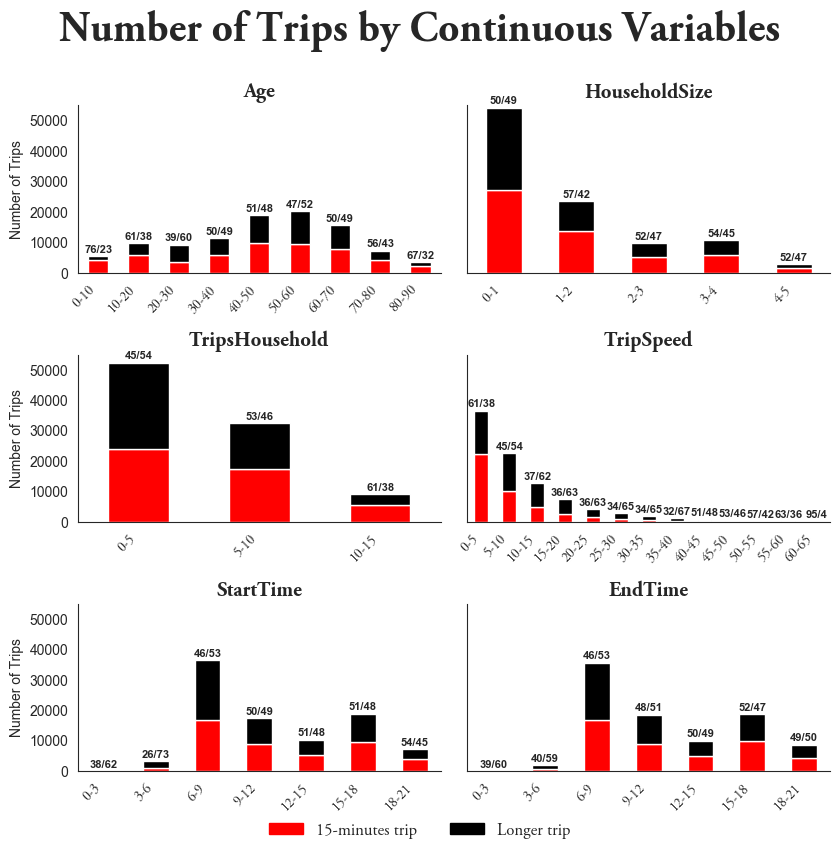

In [15]:
continuous = {
    'EDAD_FIN':('Age',(0,0)),
    'N_MIEMBROS_POR_HOGAR':('HouseholdSize',(0,1)),
    'N_VIAJES_POR_HOGAR':('TripsHousehold',(1,0)),
    'VELOCIDAD_VIAJE':('TripSpeed',(1,1)),
    'VORIHORAINI':('StartTime',(2,0)),
    'VDESHORAFIN':('EndTime',(2,1))
    }

continuous_bins = {
    'Age': np.arange(0, 100, 10),
    'HouseholdSize': np.arange(0, 6, 1),
    'TripsHousehold': np.arange(0, 20, 5),
    'TripSpeed': np.arange(0, 70, 5),
    'StartTime': np.arange(0, 24, 3),
    'EndTime': np.arange(0, 24, 3),
}


# Assuming df is already defined and loaded with your data
my_pal = {"15-minutes trip": "r", "longer trip": "k"}

# Create the new category for trips
df['15MC'] = df['TripDuration'].apply(lambda x: "15-minutes trip" if x <= 15 else "longer trip")

# Define the bin edges for each continuous variable
continuous_bins = {
    'Age': np.arange(0, 100, 10),
    'HouseholdSize': np.arange(0, 6, 1),
    'TripsHousehold': np.arange(0, 20, 5),
    'TripSpeed': np.arange(0, 70, 5),
    'StartTime': np.arange(0, 24, 3),
    'EndTime': np.arange(0, 24, 3),
}

# Clear the figure if it was used before
plt.clf()

# Set up the figure and axes for subplots, sharing y-axis for each row
fig, axs = plt.subplots(3, 2, figsize=(8.5, 8.19), sharey='row')
fig.suptitle('Number of Trips by Continuous Variables', fontweight="bold", y=1, **csfont) # Title

# Iterate over the continuous variables and create stacked bar plots
for c, i in continuous.items():
    a = axs[i[1][0]][i[1][1]]
    
    # Get the binning for the current variable
    bins = continuous_bins.get(i[0], 10)  # Default to 10 bins if not specified
    
    # Create the bucketed counts for each category ("15-minutes trip" and "longer trip")
    df['binned'] = pd.cut(df[i[0]], bins=bins)
    
    # Generate readable bin labels (e.g., "0-10", "10-20", etc.)
    df['bin_label'] = df['binned'].apply(lambda x: f"{int(x.left)}-{int(x.right)}" if pd.notna(x) else "N/A")
    
    # Group the data by bin labels and trip category, count occurrences
    trip_counts = df.groupby(['bin_label', '15MC']).size().unstack().fillna(0)
    
    # Plot stacked bar chart with readable labels
    bars = trip_counts.plot(kind='bar', stacked=True, color=[my_pal['15-minutes trip'], my_pal['longer trip']], ax=a, legend=False)
    
    # Customize the plot appearance
    a.set_title(i[0], fontweight="bold", **hfont) # Set title for each subplot
    a.set_ylabel('Number of Trips') if i[1][1] == 0 else a.set_ylabel('')  # Set y-axis label only for the left column
    a.set_xlabel('')  # Remove x-axis label for each subplot
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

    # Rotate the x-axis labels for better readability
    a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='right', fontname='Adobe Garamond Pro',)
    
    # Set the y-axis limit to a maximum of 50,000
    a.set_ylim(0, 55000)

    # Add percentage labels on top of each stacked bar
    for index, row in trip_counts.iterrows():
        red_value = row['15-minutes trip']
        black_value = row['longer trip']
        total_value = red_value + black_value
        
        if total_value > 0:
            red_pct = int((red_value / total_value) * 100)
            black_pct = int((black_value / total_value) * 100)
            
            # Get the x position (center of the bar) and y position (top of the stacked bar)
            bar_index = list(trip_counts.index).index(index)
            x = bar_index
            y = red_value + black_value
            
            # Add the label at the top of the stack
            a.text(x, y + 500, f"{red_pct}/{black_pct}", ha="center", va="bottom", fontweight="bold", fontsize=8)

fig.subplots_adjust(bottom=0.15)
legend_patches = [
    mpatches.Patch(color='red', label='15-minutes trip'),
    mpatches.Patch(color='black', label='Longer trip')
]
fig.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.03), ncol=2, frameon=False, prop={'size': 12, 'family': 'Adobe Garamond Pro'})

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.savefig(r"../figures/13_trips_by_continuous.jpg",bbox_inches="tight")

plt.show()


### Figure 14 Distribution of Density in different aggregations

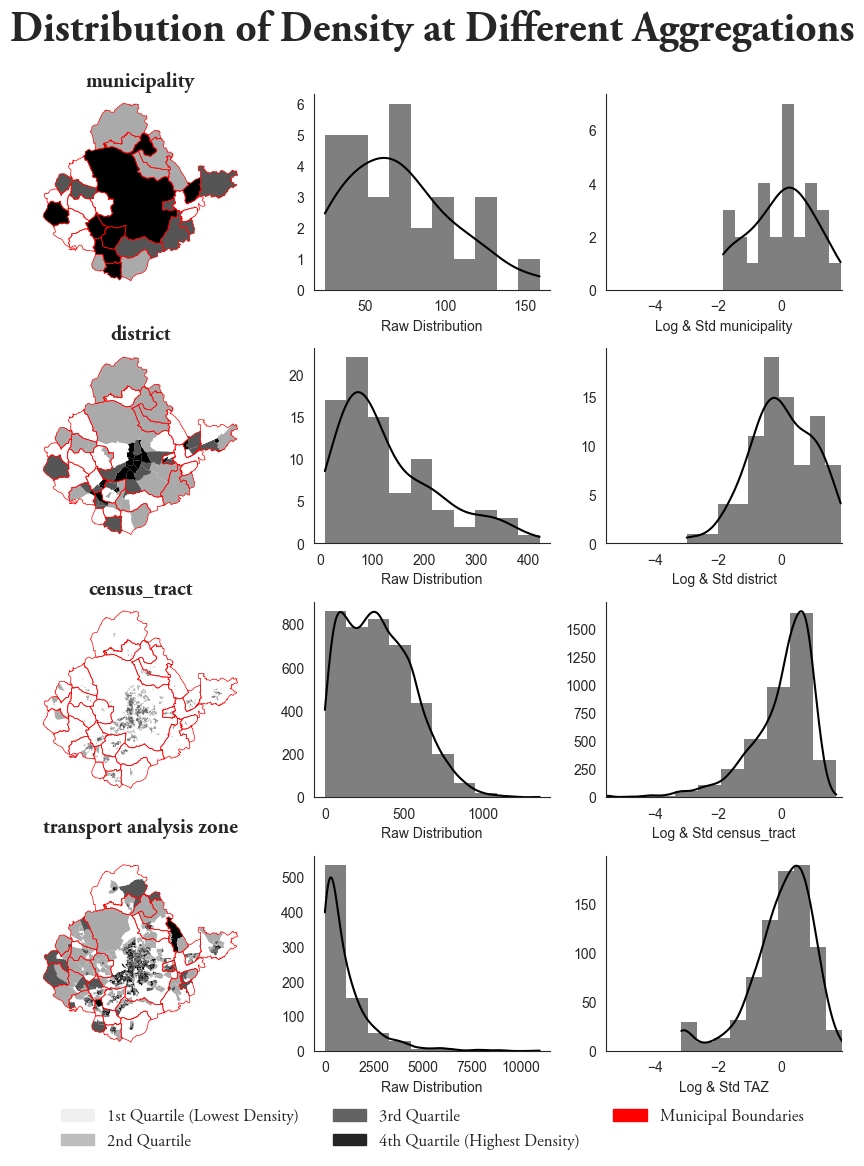

In [16]:
# Log-transform and standardize function
def log_transform_standardize(series):
    series_log = np.log1p(series)  # log1p to avoid log(0) issues
    mean_val = series_log.mean()
    std_val = series_log.std()
    
    if std_val != 0:
        standardized = (series_log - mean_val) / std_val
    else:
        standardized = series_log  # If no variability, return the series as is
    
    return standardized.replace([np.inf, -np.inf], np.nan).fillna(0)

# Compute the overall x-axis range across all groups
all_log_std_data = []
for a in ['municipality', 'district', 'census_tract']:
    log_std_density = log_transform_standardize(merged[merged['boundary_type'] == a]['NetDensity'])
    all_log_std_data.append(log_std_density)

log_std_tz_density = log_transform_standardize(merged_tz['NetDensity'])
all_log_std_data.append(log_std_tz_density)

# Find the min and max across all standardized data to use for x-axis limits
min_val = min([data.min() for data in all_log_std_data])
max_val = max([data.max() for data in all_log_std_data])

fig, axs = plt.subplots(4, 3, figsize=(8.5, 11))  # Adjust figure size for three columns
fig.suptitle('Distribution of Density at Different Aggregations', **csfont, fontweight="bold", y=1)

for i, a in enumerate(['municipality', 'district', 'census_tract']):
    # First column: maps
    ax = axs[i][0]
    merged[merged['boundary_type'] == a].plot(column='NetDensityL', categorical=True, cmap='binary', ax=ax, linewidth=0)
    muni_ref.plot(linewidth=0.5, ax=ax, color='red')
    ax.set_title(a, **hfont, fontweight="bold")
    ax.yaxis.set_label_text("")
    ax.set_xlabel('Quartiles Map')
    ax.axis('off')

    # Second column: raw histograms
    ax = axs[i][1]
    sn.histplot(data=merged[merged['boundary_type'] == a], x='NetDensity', ax=ax, edgecolor="none", bins=10, color='k', kde=True)
    ax.set_xlabel('Raw Distribution')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_label_text("")

    # Third column: log-transformed and standardized histograms with shared x-axis
    log_std_density = log_transform_standardize(merged[merged['boundary_type'] == a]['NetDensity'])
    #print(f"Original vs Log-transformed and Standardized values for {a}:\n{merged[merged['boundary_type'] == a]['NetDensity'].head()}\n{log_std_density.head()}")
    
    ax = axs[i][2]
    sn.histplot(data=log_std_density, ax=ax, edgecolor="none", bins=10, color='k', kde=True)
    ax.set_xlabel(f'Log & Std {a}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_label_text("")
    ax.set_xlim(min_val, max_val)  # Set x-axis limits for consistency

# Last row: transport analysis zone
ax = axs[3][0]
merged_tz.plot(column='NetDensityL', categorical=True, cmap='binary', ax=ax, linewidth=0)
ax.set_title('transport analysis zone', **hfont, fontweight="bold")
ax.yaxis.set_label_text("")
ax.set_xlabel('Quartiles Map')
ax.axis('off')

# Raw histogram for transport analysis zone
sn.histplot(data=merged_tz, x='NetDensity', ax=axs[3][1], edgecolor="none", bins=10, color='k', kde=True)
axs[3][1].set_xlabel('Raw Distribution')
axs[3][1].spines['top'].set_visible(False)
axs[3][1].spines['right'].set_visible(False)
axs[3][1].yaxis.set_label_text("")

# Log-transformed and standardized histogram for transport analysis zone with shared x-axis
log_std_tz_density = log_transform_standardize(merged_tz['NetDensity'])
#print(f"Original vs Log-transformed and Standardized values for TAZ:\n{merged_tz['NetDensity'].head()}\n{log_std_tz_density.head()}")

sn.histplot(data=log_std_tz_density, ax=axs[3][2], edgecolor="none", bins=10, color='k', kde=True)
axs[3][2].set_xlabel('Log & Std TAZ')
axs[3][2].spines['top'].set_visible(False)
axs[3][2].spines['right'].set_visible(False)
axs[3][2].yaxis.set_label_text("")
axs[3][2].set_xlim(min_val, max_val)  # Set x-axis limits for consistency

fig.subplots_adjust(bottom=0.05)
quartile_colors = ['#f0f0f0', '#bdbdbd', '#636363', '#252525']  # Light to dark shades of gray
legend_patches = [
    mpatches.Patch(color=quartile_colors[0], label='1st Quartile (Lowest Density)'),
    mpatches.Patch(color=quartile_colors[1], label='2nd Quartile'),
    mpatches.Patch(color=quartile_colors[2], label='3rd Quartile'),
    mpatches.Patch(color=quartile_colors[3], label='4th Quartile (Highest Density)'),
    mpatches.Patch(color='red', label='Municipal Boundaries')
]
fig.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, frameon=False, prop={'size': 12, 'family': 'Adobe Garamond Pro'})

# Final adjustments
muni_ref.plot(linewidth=0.5, ax=axs[3][0], color='red')
plt.tight_layout()
plt.savefig(r"../figures/14_distribution_of_density.jpg",bbox_inches="tight")#, pad_inches=0.2)
plt.show()


### Figure 15 Mode Prevalence and Trips by Distance

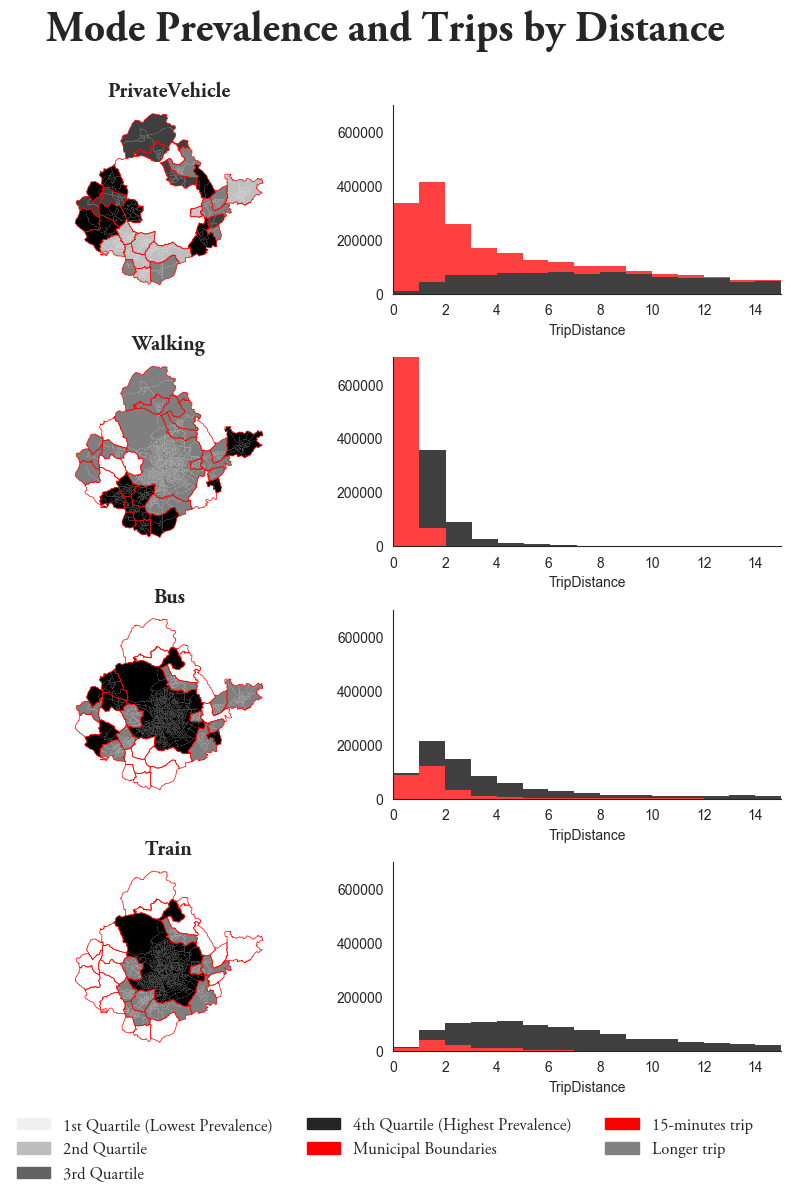

In [17]:
transport_mode = pd.merge(
df[~df['TransportMode'].isna()].groupby(['CODMUNI','TransportMode'])['ELE_G_POND'].sum().rename('typetrips').reset_index().set_index('CODMUNI'),
df[~df['TransportMode'].isna()].groupby('CODMUNI')['ELE_G_POND'].sum().rename('totaltrips'),
left_index = True,
right_index = True
)
transport_mode['ptrps'] = round(transport_mode.typetrips * 100 / transport_mode.totaltrips,0).astype(int)

my_pal = {"15-minutes trip": "r", "longer trip": "k"}

fig, ax = plt.subplots(4,2,figsize = (8.5,11))
fig.suptitle('Mode Prevalence and Trips by Distance',**csfont, fontweight="bold",y=1) # Title

gpd.GeoDataFrame(
    pd.merge(transport_mode[transport_mode['TransportMode']=='Motor - Personal']['ptrps'].rename('motor').reset_index(),gdf ,left_on='CODMUNI',right_on='CODMUNI',how='left'),geometry='geometry').plot(
        column = 'motor', scheme='natural_breaks',cmap='binary',linewidth=0, ax = ax[0][0])
muni_ref.plot(linewidth=0.5, ax = ax[0][0],color='red')
ax[0][0].set_title("PrivateVehicle", **hfont, fontweight="bold") # Y label
ax[0][0].yaxis.set_label_text("")
ax[0][0].set_xlabel('') 
ax[0][0].axis('off')

d = df[df['TransportMode']=='Motor - Personal']
d.loc[d['TripDuration']<=15,'15MC'] = "15-minutes trip"
d.loc[d['TripDuration']>15,'15MC'] = "longer trip"
sn.histplot(
    d,x='TripDistance',
    ax=ax[0][1],
    weights = 'ELE_G_POND',
    binwidth = 1,
    color='#000000',fill=True,hue='15MC',multiple='stack',palette=my_pal,linewidth=0,legend=False )
ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].yaxis.set_label_text("")
ax[0][1].set_ylim(0,700000)
ax[0][1].set_xlim(0,15)

gpd.GeoDataFrame(
    pd.merge(transport_mode[transport_mode['TransportMode']=='Walking']['ptrps'].rename('walking').reset_index(),gdf ,left_on='CODMUNI',right_on='CODMUNI',how='left'),geometry='geometry').plot(
        column = 'walking', scheme='natural_breaks',k=3,cmap='binary',linewidth=0, ax = ax[1][0])
muni_ref.plot(linewidth=0.5, ax = ax[1][0],color='red')
ax[1][0].set_title("Walking", **hfont, fontweight="bold") # Y label
ax[1][0].yaxis.set_label_text("")
ax[1][0].set_xlabel('') 
ax[1][0].axis('off')


d = df[df['TransportMode']=='Walking']
d.loc[d['TripDuration']<=15,'15MC'] = "15-minutes trip"
d.loc[d['TripDuration']>15,'15MC'] = "longer trip"
sn.histplot(
    d,x='TripDistance',
    ax=ax[1][1],
    weights = 'ELE_G_POND',
    binwidth = 1,
    color='#000000',fill=True,hue='15MC',multiple='stack',palette=my_pal,linewidth=0,legend=False)
ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].set_ylim(0,700000)
ax[1][1].set_xlim(0,15)
ax[1][1].yaxis.set_label_text("")

gpd.GeoDataFrame(
    pd.merge(transport_mode[transport_mode['TransportMode']=='Bus']['ptrps'].rename('bus').reset_index(),gdf ,left_on='CODMUNI',right_on='CODMUNI',how='left'),geometry='geometry').plot(
        column = 'bus', scheme='natural_breaks',k=3,cmap='binary',linewidth=0, ax = ax[2][0])
muni_ref.plot(linewidth=0.5, ax = ax[2][0],color='red')
ax[2][0].set_title("Bus", **hfont, fontweight="bold") # Y label
ax[2][0].yaxis.set_label_text("")
ax[2][0].set_xlabel('') 
ax[2][0].axis('off')


d = df[df['TransportMode']=='Bus']
d.loc[d['TripDuration']<=15,'15MC'] = "15-minutes trip"
d.loc[d['TripDuration']>15,'15MC'] = "longer trip"
sn.histplot(
    d,x='TripDistance',ax=ax[2][1],
    weights = 'ELE_G_POND',
    binwidth = 1,
    color='#000000',fill=True,hue='15MC',multiple='stack',palette=my_pal,linewidth=0,legend=False )
ax[2][1].spines['top'].set_visible(False)
ax[2][1].spines['right'].set_visible(False)
ax[2][1].set_ylim(0,700000)
ax[2][1].set_xlim(0,15)
ax[2][1].yaxis.set_label_text("")

gpd.GeoDataFrame(
    pd.merge(transport_mode[transport_mode['TransportMode']=='Train']['ptrps'].rename('train').reset_index(),gdf ,left_on='CODMUNI',right_on='CODMUNI',how='left'),geometry='geometry').plot(
        column = 'train', scheme='natural_breaks',k=3,cmap='binary',linewidth=0, ax = ax[3][0])
muni_ref.plot(linewidth=0.5, ax = ax[3][0],color='red')
ax[3][0].set_title("Train", **hfont, fontweight="bold") # Y label
ax[3][0].yaxis.set_label_text("")
ax[3][0].set_xlabel('') 
ax[3][0].axis('off')


d = df[df['TransportMode']=='Train']
d.loc[d['TripDuration']<=15,'15MC'] = "15-minutes trip"
d.loc[d['TripDuration']>15,'15MC'] = "longer trip"
sn.histplot(
    d,x='TripDistance',
    ax=ax[3][1],
    weights = 'ELE_G_POND',
    binwidth = 1,
    color='#000000',
    fill=True,hue='15MC',multiple='stack',palette=my_pal,linewidth=0 ,legend=False)
ax[3][1].spines['top'].set_visible(False)
ax[3][1].spines['right'].set_visible(False)
ax[3][1].set_ylim(0,700000)
ax[3][1].set_xlim(0,15)
ax[3][1].yaxis.set_label_text("")

# Adding legend
fig.subplots_adjust(bottom=0.05)
legend_patches = [
    mpatches.Patch(color=quartile_colors[0], label='1st Quartile (Lowest Prevalence)'),
    mpatches.Patch(color=quartile_colors[1], label='2nd Quartile'),
    mpatches.Patch(color=quartile_colors[2], label='3rd Quartile'),
    mpatches.Patch(color=quartile_colors[3], label='4th Quartile (Highest Prevalence)'),
    mpatches.Patch(color='red', label='Municipal Boundaries'),
    mpatches.Patch(color='red', label='15-minutes trip'),
    mpatches.Patch(color='grey', label='Longer trip')
]
fig.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=3, frameon=False, prop={'size': 12, 'family': 'Adobe Garamond Pro'})

plt.grid(False)

plt.tight_layout()
plt.savefig(r"../figures/15_mode_prevalence_distance.jpg", bbox_inches="tight")

plt.show()


### Figure 16 Number of Households Living Local

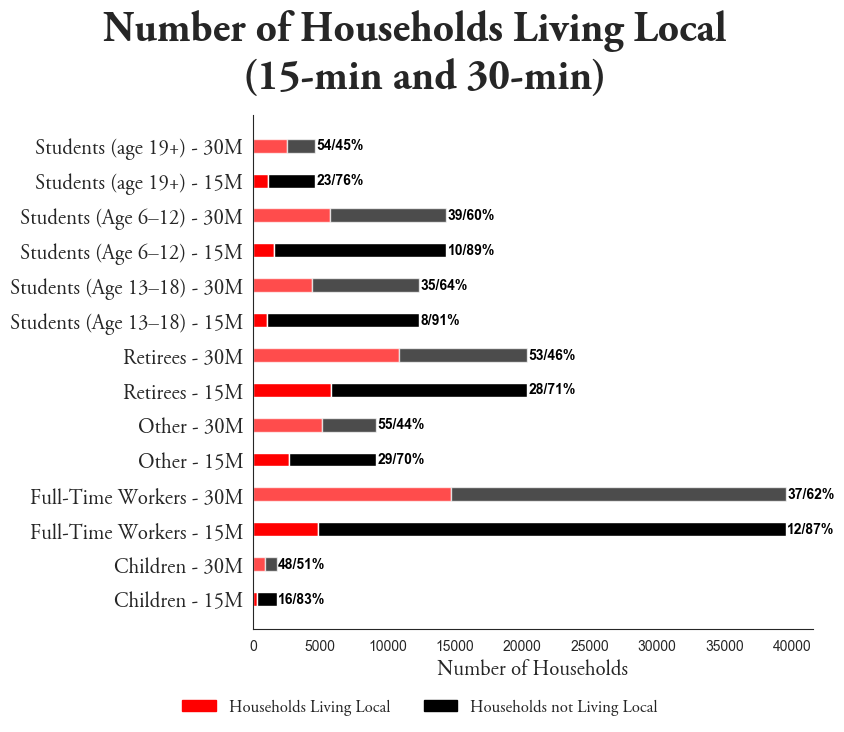

In [18]:
d = df.copy()

household_activity = pd.merge(pd.concat(
[d.groupby(['HouseholdStructure','Household15min']).count()['ID_HOGAR'].rename('type15').reset_index().set_index('HouseholdStructure'),
d.groupby(['HouseholdStructure','Household30min']).count()['ID_HOGAR'].rename('type30').reset_index().set_index('HouseholdStructure')],axis=1),
d.groupby('HouseholdStructure').count()['ID_HOGAR'].rename('totalhouseholds'), left_index=True, right_index=True
)

household_activity['p15'] = round(household_activity.type15 * 100 / household_activity.totalhouseholds,0).astype(int)
household_activity['p30'] = round(household_activity.type30 * 100 / household_activity.totalhouseholds,0).astype(int)
household_activity.reset_index(inplace=True)

# Adjusting the placement of text labels to the right end of each bar with black text color
ages = ['Children', 'Full-Time Workers', 'Other', 'Retirees', 'Students (Age 13–18)', 'Students (Age 6–12)', 'Students (age 19+)']
household_activity_15min_yes = household_activity[household_activity['Household15min'] == 'Yes']['type15'].values
household_activity_15min_no = household_activity[household_activity['Household15min'] == 'No']['type15'].values
household_activity_30min_yes = household_activity[household_activity['Household30min'] == 'Yes']['type30'].values
household_activity_30min_no = household_activity[household_activity['Household30min'] == 'No']['type30'].values

fig, ax = plt.subplots(figsize=(8.5, 7))
width = 0.4  # Width of the bar
age_indices = [i * 2 for i in range(len(ages))] + [i * 2 + 1 for i in range(len(ages))]
age_labels = [f"{age} - 15M" for age in ages] + [f"{age} - 30M" for age in ages]
# Plotting the stacked bars for each age group with text labels at the right end
for i in range(len(ages)):
    # 15-min data
    red_value_15min = household_activity_15min_yes[i]
    black_value_15min = household_activity_15min_no[i]
    total_15min = red_value_15min + black_value_15min
    
    ax.barh(i * 2, red_value_15min, color='red', height=width)
    ax.barh(i * 2, black_value_15min, left=red_value_15min, color='black', height=width)
    
    # Display text at the end of each 15-min bar
    ax.text(red_value_15min + black_value_15min + 100, i * 2, f'{int(red_value_15min / total_15min * 100)}/{int(black_value_15min / total_15min * 100)}%', 
            va='center', ha='left', color='black', fontweight='bold')
    
    # 30-min data
    red_value_30min = household_activity_30min_yes[i]
    black_value_30min = household_activity_30min_no[i]
    total_30min = red_value_30min + black_value_30min
    
    ax.barh(i * 2 + 1, red_value_30min, color='red', height=width, alpha=0.7)
    ax.barh(i * 2 + 1, black_value_30min, left=red_value_30min, color='black', height=width, alpha=0.7)
    
    # Display text at the end of each 30-min bar
    ax.text(red_value_30min + black_value_30min + 100, i * 2 + 1, f'{int(red_value_30min / total_30min * 100)}/{int(black_value_30min / total_30min * 100)}%', 
            va='center', ha='left', color='black', fontweight='bold')

# Adding labels and title
ax.set_yticks(age_indices)
ax.set_yticklabels(age_labels,  **hfont)
ax.set_xlabel('Number of Households', **hfont)
fig.suptitle('Number of Households Living Local \n (15-min and 30-min)', **csfont,fontweight="bold")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust spacing to move legend further down
fig.subplots_adjust(bottom=0.1)
legend_patches = [
    mpatches.Patch(color='red', label='Households Living Local'),
    mpatches.Patch(color='black', label='Households not Living Local')
]
fig.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False, prop={'size': 12, 'family': 'Adobe Garamond Pro'})


plt.tight_layout()
plt.savefig(r"../figures/16_households_living_localhousehold structure.jpg")
plt.show()


### Figure 18 Number of Trips by Mode and Attitude

C:\Users\katul\AppData\Local\Temp\ipykernel_972\1692763402.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(d.index, rotation=0,**hfont)
C:\Users\katul\AppData\Local\Temp\ipykernel_972\1692763402.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(d.index, rotation=0,**hfont)
C:\Users\katul\AppData\Local\Temp\ipykernel_972\1692763402.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(d.index, rotation=0,**hfont)
C:\Users\katul\AppData\Local\Temp\ipykernel_972\1692763402.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(d.index, rotation=0,**hfont)
C:\Users\katul\AppData\Local

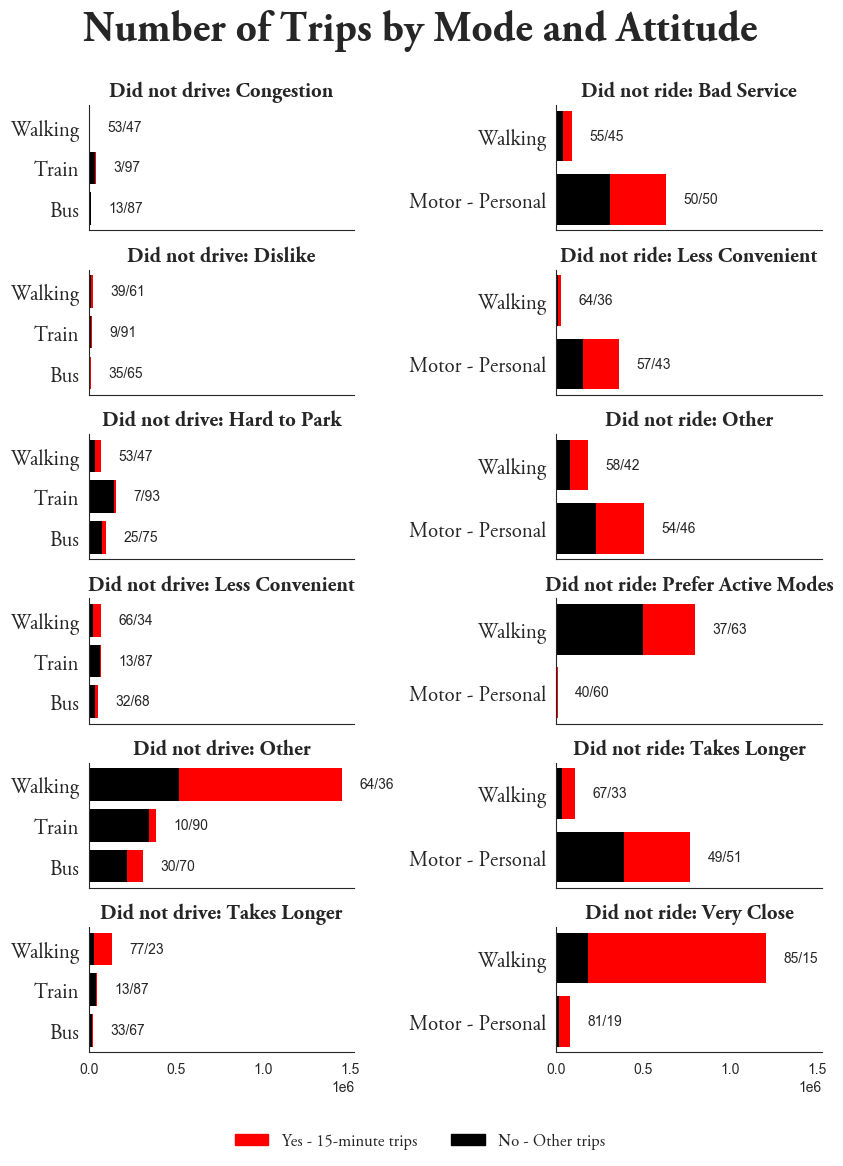

In [19]:

noprivate = sorted(df['NoPrivate'].dropna().unique())
nopublic = sorted(df['NoPublic'].dropna().unique())

fig, axs = plt.subplots(6, 2, figsize=(8.5, 11),sharex=True)


fig.suptitle('Number of Trips by Mode and Attitude', fontweight="bold", y=1, **csfont)  # Title

colors = {"Yes": "red", "No": "black"}

for i in range(0,6,1):

    for n in [0,1]:

        if n==0:
            r = 'Did not drive:'
            rs = noprivate[i]
            d = df[df['NoPrivate'] == rs]
            d = d[~d['TransportMode'].isin(['Motor - Shared','Other','Cycling'])]
            d = d[~d['TransportMode'].isin(['Motor - Personal','Motor - Shared'])].groupby(['TransportMode','Trip15'])['ELE_G_POND'].sum().unstack().fillna(0)

        else:
            rs = nopublic[i]
            d = df[df['NoPublic'] == rs]
            d = d[~d['TransportMode'].isin(['Motor - Shared','Other','Cycling'])]
            d = d.groupby(['TransportMode','Trip15'])['ELE_G_POND'].sum().unstack().fillna(0)
            
            r = 'Did not ride:'

        a = axs[i][n]

        bottom = [0] * len(d)

        for category in d.columns:
            a.barh(d.index, d[category], color=colors[category], edgecolor='none', label=category, left=bottom)
            bottom = bottom + d[category].values

        for j, (index, row) in enumerate(d.iterrows()):
            p15 = row['Yes']
            plt_ = row['No']
            total = p15 + plt_
            p15_pct = int(round((p15 / total) * 100))
            plt_pct = int(round((plt_ / total) * 100))
            label = f"{p15_pct}/{plt_pct}"
            x_pos = row['Yes'] + row['No']
            a.text(x_pos+100000, j, label,va='center',ha='left')
        
        a.set_title(f"{r} {rs}", fontweight="bold",**hfont) 
        a.set_ylabel('')
        a.set_yticklabels(d.index, rotation=0,**hfont)
        a.set_xlabel('') 
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)

# Add legend at the bottom
fig.subplots_adjust(bottom=0.15)
legend_patches = [
    mpatches.Patch(color='red', label='Yes - 15-minute trips'),
    mpatches.Patch(color='black', label='No - Other trips')
]
fig.legend(handles=legend_patches,loc='lower center', bbox_to_anchor=(0.5, -0.05),ncol=2, frameon=False, prop={'size': 12, 'family': 'Adobe Garamond Pro'})


plt.tight_layout()
plt.savefig(r"../figures/18_number_of_trips_by_mode_and_attitude.jpg",bbox_inches="tight")
plt.show()


### Figure 19 Number of Trips by Start Hour

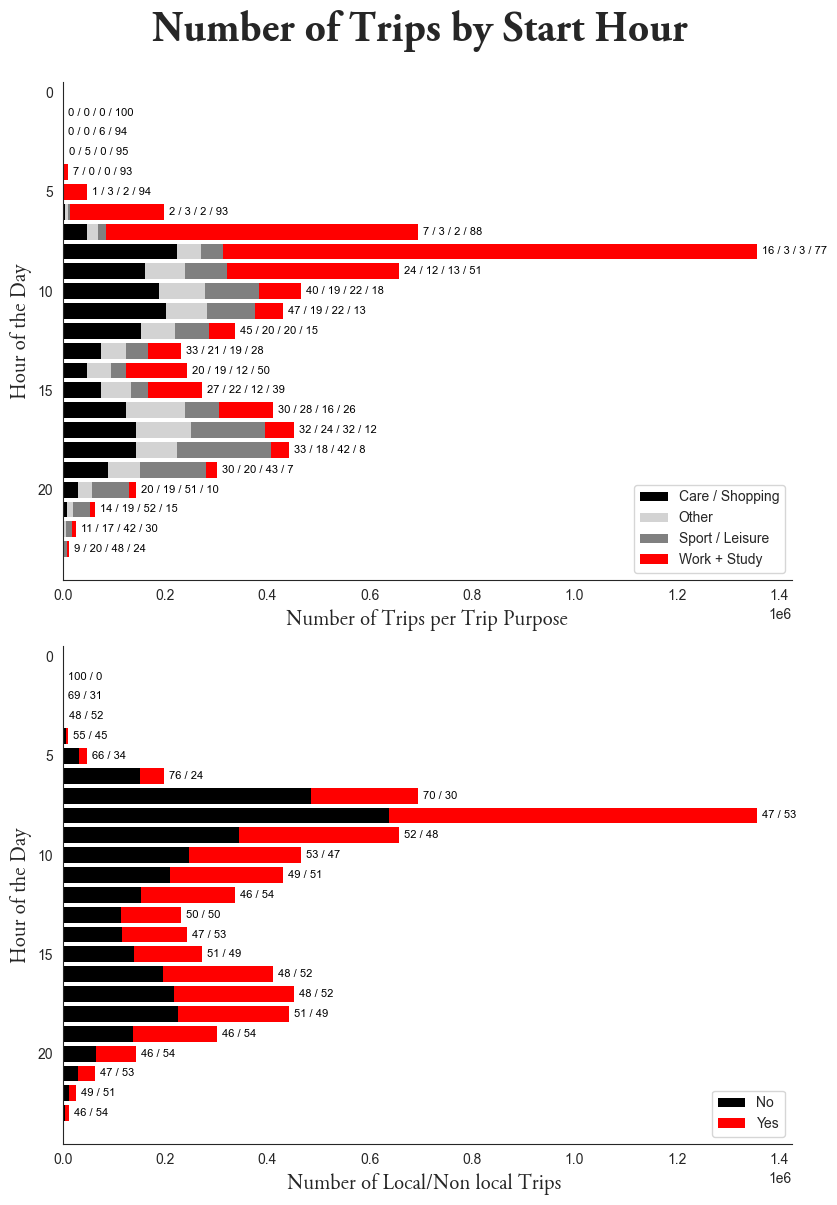

In [20]:

def plot_trip_data_with_proportions(ax, data, colors, ylabel, xlabel, legend_loc="lower right"):
    bottom = [0] * len(data)
    an_offset = 10000  # Increased offset to move the labels further right

    for category in data.columns:
        ax.barh(data.index, data[category], color=colors[category], edgecolor='none', label=category, left=bottom)
        bottom = bottom + data[category].values
    
    # Add proportion labels further past the end of each bar
    for i, (index, row) in enumerate(data.iterrows()):
        proportions = (row / row.sum() * 100).round().astype(int)  # Calculate proportions as integers
        label = " / ".join(map(str, proportions))  # Format the label
        ax.text(row.sum() + an_offset, index, label, va='center', ha='left', fontsize=8, color='black')  # Position at end

    ax.invert_yaxis()
    ax.set_ylabel(ylabel, **hfont)
    ax.set_xlabel(xlabel, **hfont)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc=legend_loc)

fig, axs = plt.subplots(2, 1, figsize=(8.5, 12))
fig.suptitle('Number of Trips by Start Hour', fontweight="bold", y=1, **csfont)

# First subplot for merged TripPurpose categories, including Other
df['MergedPurpose'] = df['TripPurpose'].replace({
    'Work': 'Work + Study', 'Study': 'Work + Study',
    'Sport / Stroll': 'Sport / Leisure', 'Leisure': 'Sport / Leisure',
    'Care': 'Care / Shopping', 'Shopping': 'Care / Shopping'
})

colors_merged_purpose = {
    'Work + Study': 'red',
    'Sport / Leisure': 'grey',
    'Care / Shopping': 'black',
    'Other': 'lightgrey'
}

data_merged_purpose = df[~df['MergedPurpose'].isna()].sort_values(by=['StartTime', 'MergedPurpose'], ascending=True)\
                      .groupby(['StartTime', 'MergedPurpose'])['ELE_G_POND'].sum().unstack().fillna(0)
data_merged_purpose = data_merged_purpose[data_merged_purpose.index != 0.0]

plot_trip_data_with_proportions(axs[0], data_merged_purpose, colors_merged_purpose, ylabel='Hour of the Day', xlabel='Number of Trips per Trip Purpose')

# Second subplot for Trip15
colors_trip_15 = {'Yes': 'r', 'No': 'k'}
data_trip_15 = df[~df['Trip15'].isna()].sort_values(by=['StartTime', 'Trip15'], ascending=True)\
                .groupby(['StartTime', 'Trip15'])['ELE_G_POND'].sum().unstack().fillna(0)
data_trip_15 = data_trip_15[data_trip_15.index != 0.0]

plot_trip_data_with_proportions(axs[1], data_trip_15, colors_trip_15, ylabel='Hour of the Day', xlabel='Number of Local/Non local Trips ')

plt.tight_layout()
r"../figures/19_number_of_trips_by_start_hour.jpg"
plt.show()


### Figure 21 Flowers of Proximity

In [21]:
modos_transporte = ['Walking', 'Bus', 'Motor - Personal', 'Train']
motivos_viaje = ['Shopping', 'Work', 'Study', 'Leisure', 'Care', 'Sport / Stroll', 'Other']
activities = ['Retired', 'Worker', 'Student', 'Caretaker']
age_statuses = ['More than 65', 'Ages 41-65', 'Ages 19-40', 'Ages 13-18', 'Ages 6-12', 'Less than 5']


#Color Scheme
colors = {
    'Walking': ['#ff9999', '#ff4d4d', '#cc0000'],  # Shades of red
    'Other Modes': ['#cccccc', 'black', '#000000']  # Shades of black
}

# Data preparation
d = df[df['TripPurpose'].isin(motivos_viaje)]

d['TransportMode'] = d['TransportMode'].replace({'Train': 'Other Modes', 'Motor - Personal': 'Other Modes', 'Bus': 'Other Modes'})
modos_transporte_simplified = ['Walking', 'Other Modes']
d = d[d['TripPurpose'].isin(motivos_viaje)]
d = d[d['TransportMode'].isin(modos_transporte_simplified)]
d = d[d['TripDistance'] < 2]
d = d[d['Activity'].isin(activities)]

def flower_of_proximity(colores_tonos, df_filtered, ax):
    if df_filtered.empty:
        return  # Skip plotting if the filtered DataFrame is empty

    # Create a complete multi-index for all combinations of TripPurpose and TransportMode
    idx = pd.MultiIndex.from_product([motivos_viaje, modos_transporte_simplified], names=['TripPurpose', 'TransportMode'])
    
    # Group and calculate metrics, then reindex to include all combinations
    mean_distances_filtered = df_filtered.groupby(['TripPurpose', 'TransportMode'])['TripDistance'].mean().reindex(idx, fill_value=0).reset_index()
    mean_distances_filtered['Max Quartile'] = df_filtered.groupby(['TripPurpose', 'TransportMode'])['TripDistance'].quantile(0.75).reindex(idx, fill_value=0).values
    mean_distances_filtered['Min Quartile'] = df_filtered.groupby(['TripPurpose', 'TransportMode'])['TripDistance'].quantile(0.25).reindex(idx, fill_value=0).values

    # Angles and colors
    num_motivos = len(motivos_viaje)
    num_bars = len(mean_distances_filtered)
    
    angle_step = 2 * np.pi / num_motivos
    bar_width = angle_step / (num_bars / num_motivos) * 0.8  # Increase spacing by reducing bar width

    # Calculate start angles and center angles for each trip purpose
    motivo_angles_start = {
        motivo: idx * angle_step
        for idx, motivo in enumerate(motivos_viaje)
    }

    motivo_angles_center = {
        motivo: (idx * angle_step) + (angle_step / 2)
        for idx, motivo in enumerate(motivos_viaje)
    }

    for i, row in mean_distances_filtered.iterrows():
        trip_purpose = row['TripPurpose']
        angle = motivo_angles_start[trip_purpose] + ((i % (num_bars // num_motivos)) * bar_width)
        modo = row['TransportMode']
        ax.bar(x=angle, height=row['Min Quartile'], width=bar_width, color=colores_tonos[modo][0], linewidth=0.1, edgecolor='b')
        ax.bar(x=angle, height=row['TripDistance'] - row['Min Quartile'], width=bar_width, bottom=row['Min Quartile'], color=colores_tonos[modo][1], linewidth=0.1, edgecolor='b')
        ax.bar(x=angle, height=row['Max Quartile'] - row['TripDistance'], width=bar_width, bottom=row['TripDistance'], color=colores_tonos[modo][2], alpha=0.6, linewidth=0.1, edgecolor='b',
               label=modo if i % (num_bars // len(modos_transporte_simplified)) == 0 else "")

    # Set the ticks and labels at the center of each segment
    ax.set_xticks([motivo_angles_center[motivo] for motivo in motivos_viaje])
    ax.set_xticklabels([])  # Remove default labels

    # Add custom labels with larger font size and adjust their positions
    label_distance = 2.2  # Distance from the center
    label_angle_adjustment = bar_width / 2  # Adjust by half the bar width
    rotation_offset = -np.radians(10)  # 10 degrees in radians

    for trip_purpose, angle in motivo_angles_center.items():
        adjusted_angle = angle + label_angle_adjustment + rotation_offset
        ax.text(adjusted_angle, label_distance, trip_purpose, horizontalalignment='center', color='black', weight='bold', rotation=np.degrees(adjusted_angle), rotation_mode='anchor', size=10, fontname='Adobe Garamond Pro')

    # Draw reference circles and labels
    for distance in np.arange(0.5, 2.5, 0.5):
        linestyle = '--'
        linewidth = 0.5
        color = 'grey'

        # Highlight the 1500 meters (1.5 km) line
        if distance == 1.5:
            linestyle = '-'
            linewidth = 1
            color = 'black'

        ax.plot(np.linspace(0, 2 * np.pi, 100), np.ones(100) * distance, color=color, linestyle=linestyle, linewidth=linewidth, zorder=0)


    # Remove radial lines
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.yaxis.set_tick_params(width=0)
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_yticklabels([])

    plt.ylim(0, 2)

def create_plots(valid_combinations, activities, age_statuses, filename, ncols, show_legend):
    fig, axes = plt.subplots(len(age_statuses), len(activities), figsize=(ncols * 5, 15), subplot_kw=dict(polar=True), sharey=True)

    if len(activities) == 1:
        axes = np.expand_dims(axes, axis=-1)

    # Add the column titles
    for ax, activity in zip(axes[0], activities):
        ax.set_title(activity, pad=60, **csfont)

    # Add the row titles
    for ax, age_status in zip(axes[:, 0], age_statuses):
        ax.annotate(age_status, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 50, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    ha='center', va='center', rotation=90, **hfont)

    for i, activity in enumerate(activities):
        for j, age_status in enumerate(age_statuses):
            ax = axes[j, i]
            if (activity, age_status) in valid_combinations:
                df_filtered = d[(d['Activity'] == activity) & (d['Age Status'] == age_status)]
                flower_of_proximity(colors, df_filtered, ax)
            else:
                ax.axis('off')

    if show_legend:
            fig.subplots_adjust(bottom=0.2)
            
            # Patch Legend
            legend_patches = [
                mpatches.Patch(color=colors['Walking'][0], label='Walking - Min Quartile'),
                mpatches.Patch(color=colors['Walking'][1], label='Walking - Mean to Min Quartile'),
                mpatches.Patch(color=colors['Walking'][2], label='Walking - Max Quartile to Mean'),
                mpatches.Patch(color=colors['Other Modes'][0], label='Other Modes - Min Quartile'),
                mpatches.Patch(color=colors['Other Modes'][1], label='Other Modes - Mean to Min Quartile'),
                mpatches.Patch(color=colors['Other Modes'][2], label='Other Modes - Max Quartile to Mean')
            ]
            
            fig.legend(handles=legend_patches, loc='lower right', ncol=3, frameon=False, prop={'size': 14, 'family': 'Adobe Garamond Pro'})
            
            # Reference Lines Legend - aligned to the first patches in the patches legend
            ref_legend_ax = fig.add_axes([0.3, 0.12, 0.12, 0.08])  # Moved right to align with patch legend
            ref_legend_ax.axis('off')
            for distance in [0.5, 1.0, 1.5, 2.0]:
                ref_legend_ax.plot(
                    [0.0, 0.05], [distance, distance],  # Shortened horizontal lines
                    color='grey' if distance != 1.5 else 'black',
                    linestyle='--' if distance != 1.5 else '-',
                    linewidth=0.8 if distance != 1.5 else 1.2
                )
                ref_legend_ax.text(0.06, distance, f'{int(distance * 1000)} m', ha='left', va='center', fontsize=10, fontname='Adobe Garamond Pro')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.savefig(filename)
    plt.show()


C:\Users\katul\AppData\Local\Temp\ipykernel_972\3764485059.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['TransportMode'] = d['TransportMode'].replace({'Train': 'Other Modes', 'Motor - Personal': 'Other Modes', 'Bus': 'Other Modes'})


C:\Users\katul\AppData\Local\Temp\ipykernel_972\3764485059.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\katul\AppData\Local\Temp\ipykernel_972\3764485059.py:153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 1])


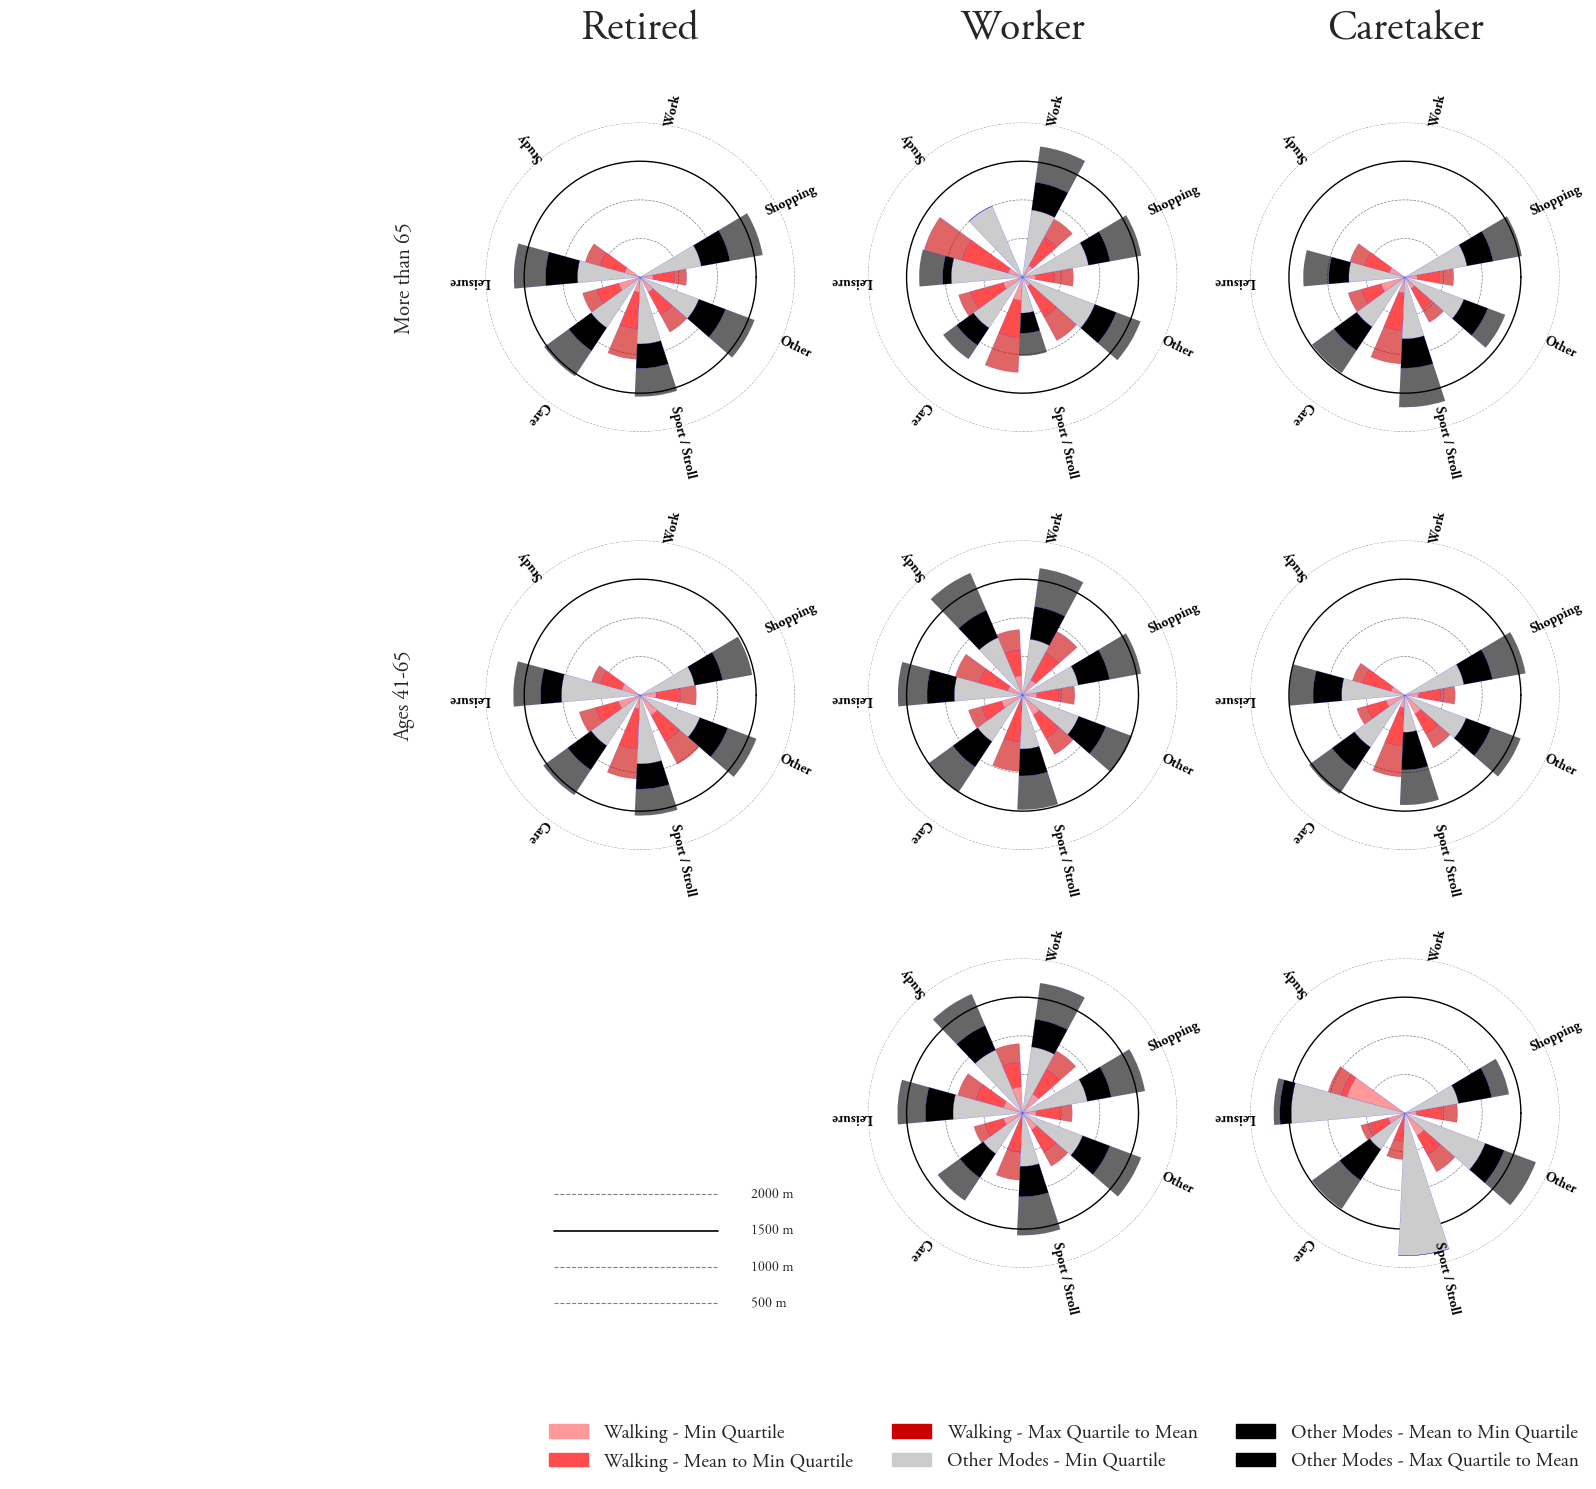

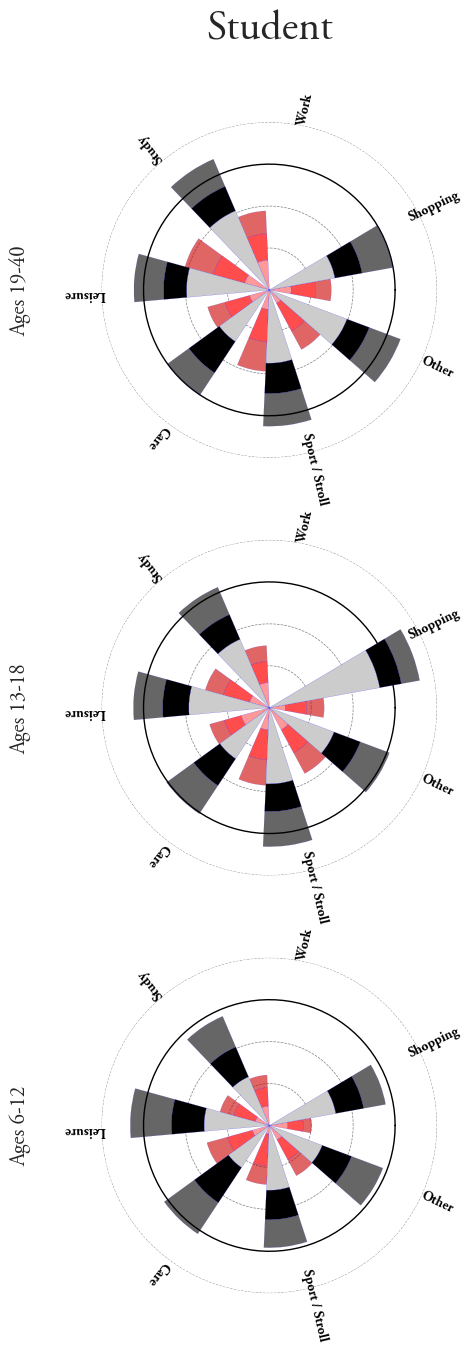

In [22]:
# Create first figure
valid_combinations_1 = [("Retired", "More than 65"), ("Retired", "Ages 41-65"), 
                        ("Worker", "More than 65"), ("Worker", "Ages 41-65"), ("Worker", "Ages 19-40"),
                        ("Caretaker", "More than 65"), ("Caretaker", "Ages 41-65"), ("Caretaker", "Ages 19-40")]

activities_1 = ['Retired', 'Worker', 'Caretaker']
age_statuses_1 = ['More than 65', 'Ages 41-65', 'Ages 19-40']
create_plots(valid_combinations_1, activities_1, age_statuses_1, r"../figures/21_flowers_of_proximity_1.jpg", 3, True) 

# Create second figure
valid_combinations_2 = [("Student", "Ages 19-40"), ("Student", "Ages 13-18"), ("Student", "Ages 6-12")]
activities_2 = ['Student']
age_statuses_2 = ['Ages 19-40', 'Ages 13-18', 'Ages 6-12']
create_plots(valid_combinations_2, activities_2, age_statuses_2, r"../figures/21_flowers_of_proximity_2.jpg", 1, False)

In [23]:
### Table for Figure-Table 7 (deprecated)

In [24]:
def generate_complete_table(d, valid_combinations):
    """
    Generate a complete table with values for all valid combinations.

    Args:
        d (pd.DataFrame): Original dataset.
        valid_combinations (list of tuples): List of (Activity, Age Cohort) valid combinations.

    Returns:
        pd.DataFrame: Complete table for all combinations.
    """
    all_tables = []

    for activity, age_status in valid_combinations:
        # Filter data for the current activity and age cohort
        df_filtered = d[(d['Activity'] == activity) & (d['Age Status'] == age_status)]

        if df_filtered.empty:
            continue  # Skip if there are no data for the current combination

        # Create a complete multi-index for all combinations of TripPurpose and TransportMode
        idx = pd.MultiIndex.from_product([motivos_viaje, modos_transporte_simplified], names=['TripPurpose', 'TransportMode'])

        # Group and calculate metrics, then reindex to include all combinations
        mean_distances_filtered = df_filtered.groupby(['TripPurpose', 'TransportMode'])['TripDistance'].mean().reindex(idx, fill_value=0).reset_index()
        mean_distances_filtered['Max Quartile'] = df_filtered.groupby(['TripPurpose', 'TransportMode'])['TripDistance'].quantile(0.75).reindex(idx, fill_value=0).values
        mean_distances_filtered['Min Quartile'] = df_filtered.groupby(['TripPurpose', 'TransportMode'])['TripDistance'].quantile(0.25).reindex(idx, fill_value=0).values

        # Add columns for Activity, Age Cohort, and Elevator Sum
        mean_distances_filtered['Activity'] = activity
        mean_distances_filtered['Age Cohort'] = age_status
        mean_distances_filtered['Elevator Sum'] = df_filtered['ELE_G_POND'].sum()

        # Rename columns for clarity
        mean_distances_filtered.rename(columns={
            'TripPurpose': 'Trip Purpose',
           
            'TransportMode': 'Transport Mode',
            'TripDistance': 'Mean Distance'
        }, inplace=True)

        # Reorder columns for clarity
        mean_distances_filtered = mean_distances_filtered[['Activity', 'Age Cohort', 'Trip Purpose', 'Transport Mode', 'Mean Distance', 'Min Quartile', 'Max Quartile', 'Elevator Sum']]

        # Append to the list of all tables
        all_tables.append(mean_distances_filtered)

    # Concatenate all individual tables into a single DataFrame
    complete_table = pd.concat(all_tables, ignore_index=True)

    return complete_table

# Generate the complete table for all valid combinations
valid_combinations = [
    ("Retired", "More than 65"), ("Retired", "Ages 41-65"),
    ("Worker", "More than 65"), ("Worker", "Ages 41-65"), ("Worker", "Ages 19-40"),
    ("Caretaker", "More than 65"), ("Caretaker", "Ages 41-65"), ("Caretaker", "Ages 19-40"),
    ("Student", "Ages 19-40"), ("Student", "Ages 13-18"), ("Student", "Ages 6-12")
]

# Generate the table
complete_table = generate_complete_table(d, valid_combinations)

# Print the table to copy and paste
print(complete_table.to_string(index=False, float_format="{:.2f}".format))


 Activity   Age Cohort   Trip Purpose Transport Mode  Mean Distance  Min Quartile  Max Quartile  Elevator Sum
  Retired More than 65       Shopping        Walking           0.44          0.17          0.60     634782.99
  Retired More than 65       Shopping    Other Modes           1.18          0.80          1.61     634782.99
  Retired More than 65           Work        Walking           0.00          0.00          0.00     634782.99
  Retired More than 65           Work    Other Modes           0.00          0.00          0.00     634782.99
  Retired More than 65          Study        Walking           0.00          0.00          0.00     634782.99
  Retired More than 65          Study    Other Modes           0.00          0.00          0.00     634782.99
  Retired More than 65        Leisure        Walking           0.54          0.21          0.74     634782.99
  Retired More than 65        Leisure    Other Modes           1.22          0.81          1.63     634782.99
  Retired 

### Figure 23 Mode Choice for 15M Trips

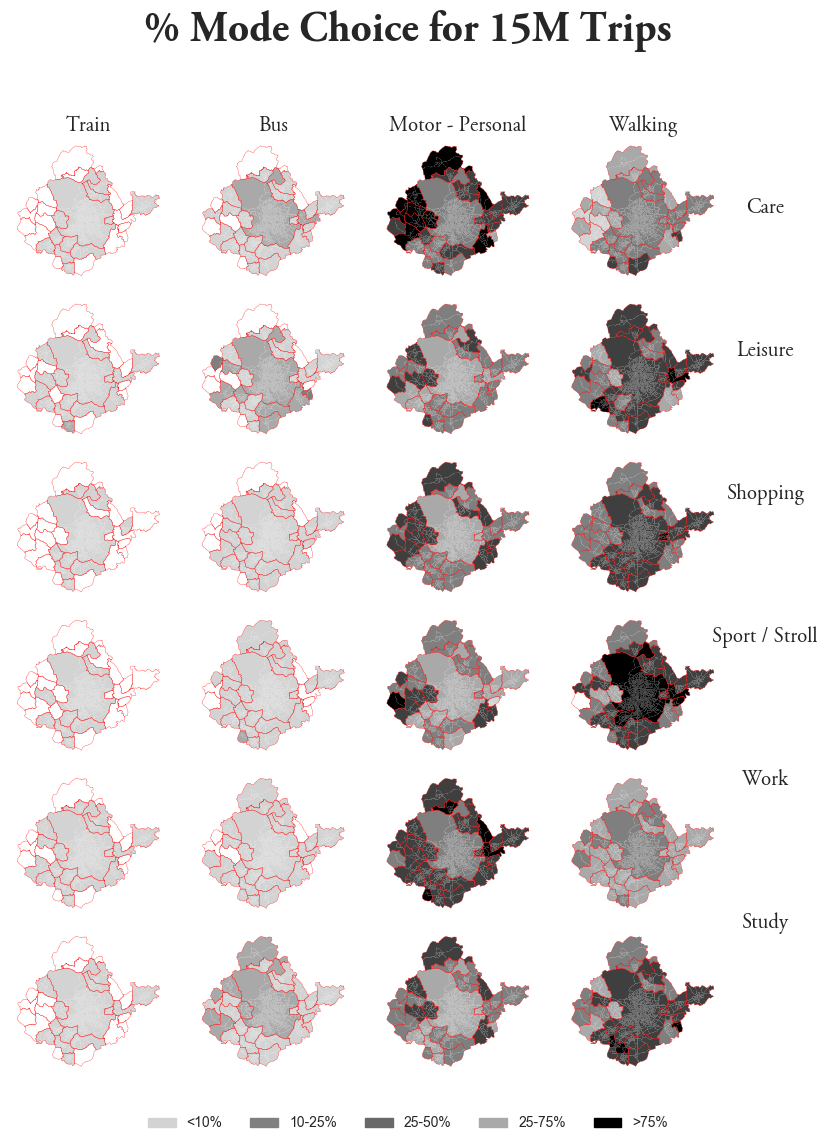

In [43]:
transport_mode = pd.merge(
df[(df['TransportMode'].notnull())&(df['Trip15']=='Yes')].groupby(['CODMUNI','TripPurpose','TransportMode'])['ELE_G_POND'].sum().rename('typetrips').reset_index().set_index(['CODMUNI','TripPurpose']),
df[(df['TransportMode'].notnull())&(df['Trip15']=='Yes')].groupby(['CODMUNI','TripPurpose'])['ELE_G_POND'].sum().rename('totaltrips').reset_index().set_index(['CODMUNI','TripPurpose']),
left_index = True,
right_index = True
)
transport_mode['ptrps'] = round(transport_mode.typetrips * 100 / transport_mode.totaltrips,0).astype(int)

transport_mode.reset_index(inplace=True)

transport_mode.set_index('CODMUNI',inplace=True)

def make_plot(cax, mode, purpose):
    
    cmap = mcolors.LinearSegmentedColormap.from_list("grey_scale", ["lightgrey", "grey", "black"])
    bins = [0, 10, 25, 50 , 75, 100]  # Change as per your data range
    labels = ['<10%', '10-25%', '25-50%', '25-75%', '>75%']

    g = gpd.GeoDataFrame(
        pd.merge(transport_mode[(transport_mode['TransportMode']==mode)&(transport_mode['TripPurpose']==purpose)]['ptrps'].rename(f"{mode}-{purpose}").reset_index(),gdf ,left_on='CODMUNI',right_on='CODMUNI',how='left'),geometry='geometry')
    if not g.empty:
        g['binned'] = pd.cut(g[f"{mode}-{purpose}"], bins=bins, labels=labels, include_lowest=True)
        g.plot(
                column = f"binned", cmap=cmap ,linewidth=0, ax = cax)
        muni_ref.plot(linewidth=0.2, ax = cax,color='red')
    else: muni_ref.plot(linewidth=0.00, ax = cax,color='red')
        #ax[3][0].set_title("Train", **hfont, fontweight="bold") # Y label
    cax.yaxis.set_label_text("")
    cax.set_xlabel('') 
    cax.axis('off')

fig, ax = plt.subplots(6,4,figsize=(8.5,11),sharey=True,sharex=True)

# Apply the make_plot function for each row and column
modes = ['Train', 'Bus', 'Motor - Personal', 'Walking']
purposes = ['Care', 'Leisure', 'Shopping', 'Sport / Stroll', 'Work', 'Study']

for i, purpose in enumerate(purposes):
    make_plot(ax[i][0], 'Train',purpose)
    make_plot(ax[i][1], 'Bus',purpose)
    make_plot(ax[i][2], 'Motor - Personal',purpose)
    make_plot(ax[i][3], 'Walking',purpose)


# Add the global title
fig.suptitle('% Mode Choice for 15M Trips', fontweight='bold',**csfont)

# Add column titles
column_titles = ['Train', 'Bus', 'Motor - Personal', 'Walking']
for i, title in enumerate(column_titles):
    ax[0][i].set_title(title, **hfont)

# Add row titles (on the right side)
row_titles = ['Care', 'Leisure', 'Shopping', 'Sport / Stroll', 'Work', 'Study']
for i, title in enumerate(row_titles):
    fig.text(0.92, (5 - i) * 0.13 + 0.15, title, va='center', ha='center', **hfont)

legend_labels = ['<10%', '10-25%', '25-50%', '25-75%', '>75%']
colors = ["lightgrey", "grey", "dimgray", "darkgrey", "black"]
patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]

# Add legend outside the plot
fig.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5, frameon=False)#,**csfont)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for titles and legend
plt.savefig(r"../figures/23_mode_choice_for_15m_trips.jpg", bbox_inches="tight")
plt.show()
    


### Table 7

In [ ]:
env = pd.read_csv(r"G:\Mi unidad\walknet_datalake\extractions\fn_landuse_on_tz.csv")

iterates = pd.read_csv(r"../sources/ite_rates.csv",sep=";")
iterates = iterates[iterates['TripPurpose'].notnull()]
iterates.loc[iterates['Unit of Measure']==' 1,000 SF GFA','ITE Rates'] = round((iterates[iterates['Unit of Measure']==' 1,000 SF GFA'][' Trips Per Unit 1']) / 92.903,3)
iterates.loc[iterates['Unit of Measure']==' Acres','ITE Rates'] = round((iterates[iterates['Unit of Measure']==' Acres'][' Trips Per Unit 1']) / 92.903,3)
iterates.loc[iterates['Unit of Measure']==' Dwelling Units','ITE Rates'] = (iterates[iterates['Unit of Measure']==' Dwelling Units'][' Trips Per Unit 1'])
iterates['Cadastral'] = iterates['Cadastral'].str.strip()
iterates['Cadastral'].unique()
iterates['TripPurpose'] = iterates['TripPurpose'].str.strip()

env['boundary_type']= 'tz'

areas_edm = env.groupby('boundary_type') [['housing_area','care_area', 'school_area','leisure_area','shopping_area', 'sport_area']].sum().unstack().reset_index()
areas_edm = areas_edm.rename(columns={'level_0':'Cadastral',0:'Area/Units'}).drop(columns=['boundary_type'])
areas_edm = pd.Series(areas_edm['Area/Units'].values,index=areas_edm['Cadastral']).to_dict()

iterates['Area/Units'] = iterates['Cadastral'].map(areas_edm)

d = df[df['TransportMode'] == 'Motor - Personal']
trips = d.groupby(['TripPurpose'])['ELE_G_POND'].sum().reset_index().rename(columns={'ELE_G_POND':'Trips'})
trips = pd.Series(trips['Trips'].values,index=trips['TripPurpose']).to_dict()
iterates['Car Trips'] = iterates['TripPurpose'].map(trips)

iterates = iterates[(iterates['Car Trips'].notnull())&(iterates['Area/Units'].notnull())]
iterates['Car Trips Rate'] =  round(iterates['Car Trips'] / iterates['Area/Units'],3)

d = df[df['TransportMode'] == 'Walking']
trips = d.groupby(['TripPurpose'])['ELE_G_POND'].sum().reset_index().rename(columns={'ELE_G_POND':'Trips'})
trips = pd.Series(trips['Trips'].values,index=trips['TripPurpose']).to_dict()
iterates['Walk Trips'] = iterates['TripPurpose'].map(trips)
iterates = iterates[(iterates['Walk Trips'].notnull())&(iterates['Area/Units'].notnull())]
iterates['Walk Trips Rate'] =  round(iterates['Walk Trips'] / iterates['Area/Units'],3)

d = df[(df['TransportMode'] == 'Walking')&(df['Trip15']=='Yes')]
trips = d.groupby(['TripPurpose'])['ELE_G_POND'].sum().reset_index().rename(columns={'ELE_G_POND':'Trips'})
trips = pd.Series(trips['Trips'].values,index=trips['TripPurpose']).to_dict()
iterates['Walk Trips 15M'] = iterates['TripPurpose'].map(trips)
iterates = iterates[(iterates['Walk Trips 15M'].notnull())&(iterates['Area/Units'].notnull())]
iterates['Walk Trips 15M Rate'] =  round(iterates['Walk Trips 15M'] / iterates['Area/Units'],3)

d = df[(df['TransportMode'] == 'Motor - Personal')&(df['Trip15']=='Yes')]
trips = d.groupby(['TripPurpose'])['ELE_G_POND'].sum().reset_index().rename(columns={'ELE_G_POND':'Trips'})
trips = pd.Series(trips['Trips'].values,index=trips['TripPurpose']).to_dict()
iterates['Car Trips 15M'] = iterates['TripPurpose'].map(trips)
iterates = iterates[(iterates['Car Trips 15M'].notnull())&(iterates['Area/Units'].notnull())]
iterates['Car Trips 15M Rate'] =  round(iterates['Car Trips 15M'] / iterates['Area/Units'],3)

iterates['Area/Units'] = iterates['Area/Units'].astype(int)
iterates['Car Trips'] = iterates['Car Trips'].astype(int)
iterates['Car Trips'] = iterates['Car Trips 15M'].astype(int)
iterates['Walk Trips'] = iterates['Walk Trips'].astype(int)
iterates['Walk Trips 15M'] = iterates['Walk Trips 15M'].astype(int)

st = iterates.groupby(['TripPurpose','Car Trips','Car Trips 15M','Walk Trips','Walk Trips 15M','Area/Units','Walk Trips 15M Rate','Walk Trips Rate','Car Trips 15M Rate','Car Trips Rate',' Description'])[['ITE Rates']].max()

st.to_excel(r"../figures/trip_rates.xlsx")



In [40]:
st

ITE Rates
TripPurpose    Car Trips Car Trips 15M Walk Trips Walk Trips 15M Area/Units Walk Trips 15M Rate Walk Trips Rate Car Trips 15M Rate Car Trips Rate  Description                                                 
Care           281246    281246.896321 270816     204107         4099029    0.050               0.066           0.069              0.106          Assisted Living                                         0.005
                                                                                                                                                  Clinic                                                  0.035
                                                                                                                                                  Daycare Center                                          0.120
                                                                                                                                                  Hospital                                                0.010
                                                                                                                                                  Nursing Home                                            0.006
Leisure        52541     52541.120213  155876     105582         3681601    0.029               0.042           0.014              0.027          Arena                                                   0.005
                                                                                                                                                  Bread / Donut / Bagel Shop without Drive-Throug...      0.301
                                                                                                                                                  Coffee/Donut Shop without Drive-Through Window          0.391
                                                                                                                                                  Drinking Place                                          0.122
                                                                                                                                                  Fast Casual Restaurant                                  0.152
                                                                                                                                                  Fast Food Restaurant without Drive-Through Window       0.305
                                                                                                                                                  High-Turnover (Sit-Down) Restaurant                     0.105
                                                                                                                                                  Library                                                 0.088
                                                                                                                                                  Movie Theater                                           0.066
                                                                                                                                                  Multi-Purpose Recreational Facility                     0.039
                                                                                                                                                  Multiplex Movie Theater                                 0.053
                                                                                                                                                  Museum                                                  0.002
                                                                                                                                                  Quality Restaurant                                      0.084
                                      